In [130]:
from Bio import SeqIO
from Bio.Seq import Seq
import collections
import array
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from suffix_trees import STree
from datetime import datetime
import sys
import random
from bitarray import bitarray
import csv
import bwt
import re
from pydivsufsort import divsufsort
from pydivsufsort import bw_transform
from memory_profiler import profile
import psutil
import tracemalloc
from pprint import pprint
int_max = (2**31) - 1
print(int_max)

2147483647


TASK1 --> getting to know about the data

In [131]:
for seq_record in SeqIO.parse("chrX.fa", "fasta"):
    print(seq_record)
    sequence = seq_record.seq


ID: chrX
Name: chrX
Description: chrX
Number of features: 0
Seq('CTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTCTGAAAGTGGACCTAT...GGT')


In [132]:
#reference sequence
ref_seq = str(sequence)

In [133]:
def get_count(Seq):
    counts = [0 for i in range(4)]
    for i in Seq:
        if i == 'A' :
            counts[0] += 1
        elif i == 'C' :
            counts[1] += 1
        elif i == 'G' :
            counts[2] += 1
        elif i == 'T' :
            counts[3] += 1
    return counts

In [134]:
ref_bases_count = get_count(ref_seq)

In [135]:
counter = 0
with open('reads','r') as reads:
        read_seq = ""
        for line in reads:
                read_seq += line.strip()
                if 'N' in line.strip() :
                        counter = counter + 1
        reads_bases_count = get_count(read_seq)
print(f"Total no of reads that contains character 'N' {counter}")

Total no of reads that contains character 'N' 2453


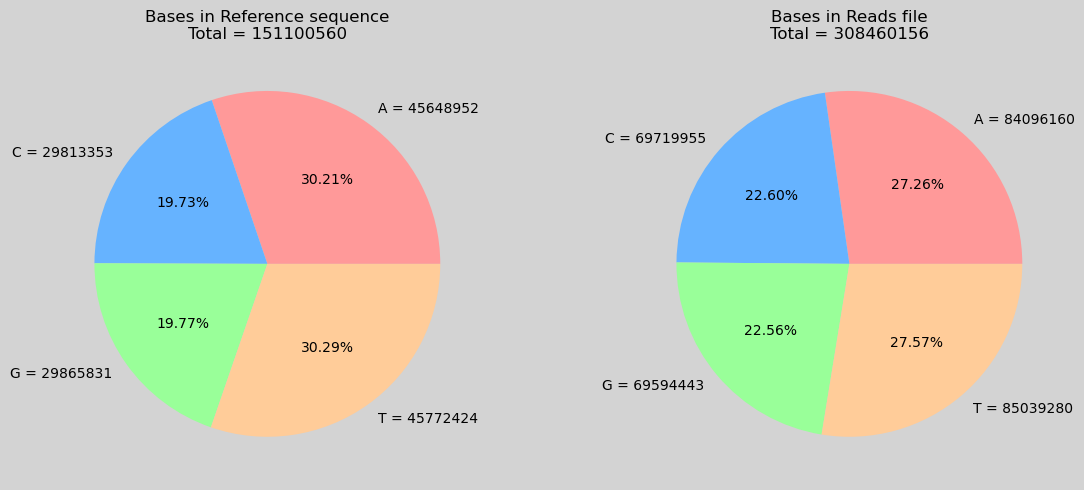

In [136]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
ax1.pie(ref_bases_count,colors=colors ,labels=['A = '+str(ref_bases_count[0]),'C = '+str(ref_bases_count[1]),'G = '+str(ref_bases_count[2]),'T = '+str(ref_bases_count[3])], autopct='%1.2f%%')
ax1.set_title('Bases in Reference sequence\nTotal = '+str(sum(ref_bases_count)))

ax2.pie(reads_bases_count,colors=colors ,labels=['A = '+str(reads_bases_count[0]),'C = '+str(reads_bases_count[1]),'G = '+str(reads_bases_count[2]),'T = '+str(reads_bases_count[3])], autopct='%1.2f%%')
ax2.set_title('Bases in Reads file\nTotal = '+str(len(read_seq)))
plt.tight_layout()
fig.patch.set_facecolor('lightgray')
plt.show()

In [137]:
filename = "chrX_last_col.txt"
with open(filename, "r") as file:
    length = 0
    last_column = ""
    for line in (file):
        Str = line.strip()
        last_column+=Str
        length += len(Str)
    print(length)
    print(len(last_column))


151100561
151100561


In [138]:
filen = "chrX_map.txt"
with open(filen, "r") as file:
    for index, line in enumerate(file):
        print(line.strip())
        if index == 5:
            break


74645898
74645899
74645900
74645901
74645902
74645903


In [139]:
filen = "reads"
reads_len_dict = {}
with open(filen, "r") as file:
    for line in file:
        Str = line.strip()
        n = len(Str)
        if reads_len_dict.get(n) != None:
            reads_len_dict[n] += 1
        else:
            reads_len_dict[n] = 1


In [141]:
lengths = list(reads_len_dict.keys())
values = list(reads_len_dict.values())

In [142]:
df = pd.DataFrame()
df['length'] = lengths
df['vals'] = values
df = df.sort_values(by='vals')


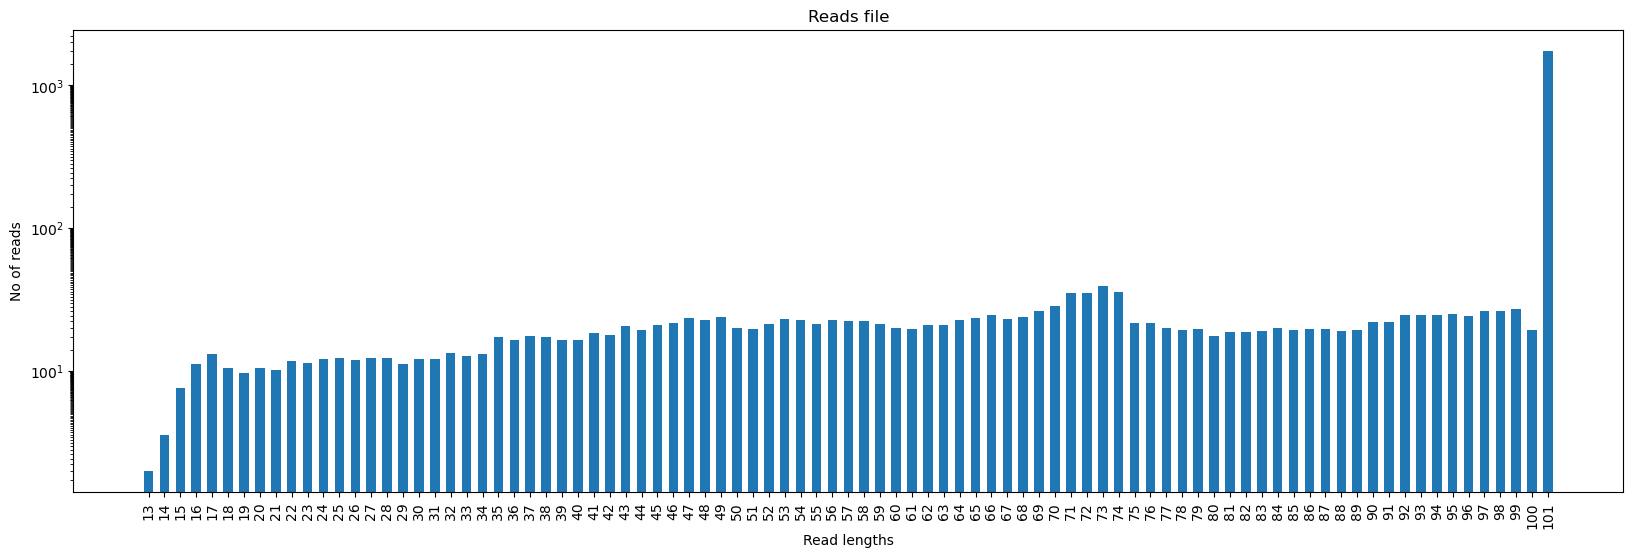

In [143]:
fig, ax = plt.subplots(figsize=(20, 6))
bars = plt.bar(df['length'], df['vals'], align='center', width=0.6)

plt.yscale('log', base=100)
plt.xlabel("Read lengths")
plt.ylabel("No of reads")
plt.title("Reads file")
plt.xticks(df['length'], df['length'], rotation=90)
plt.show()


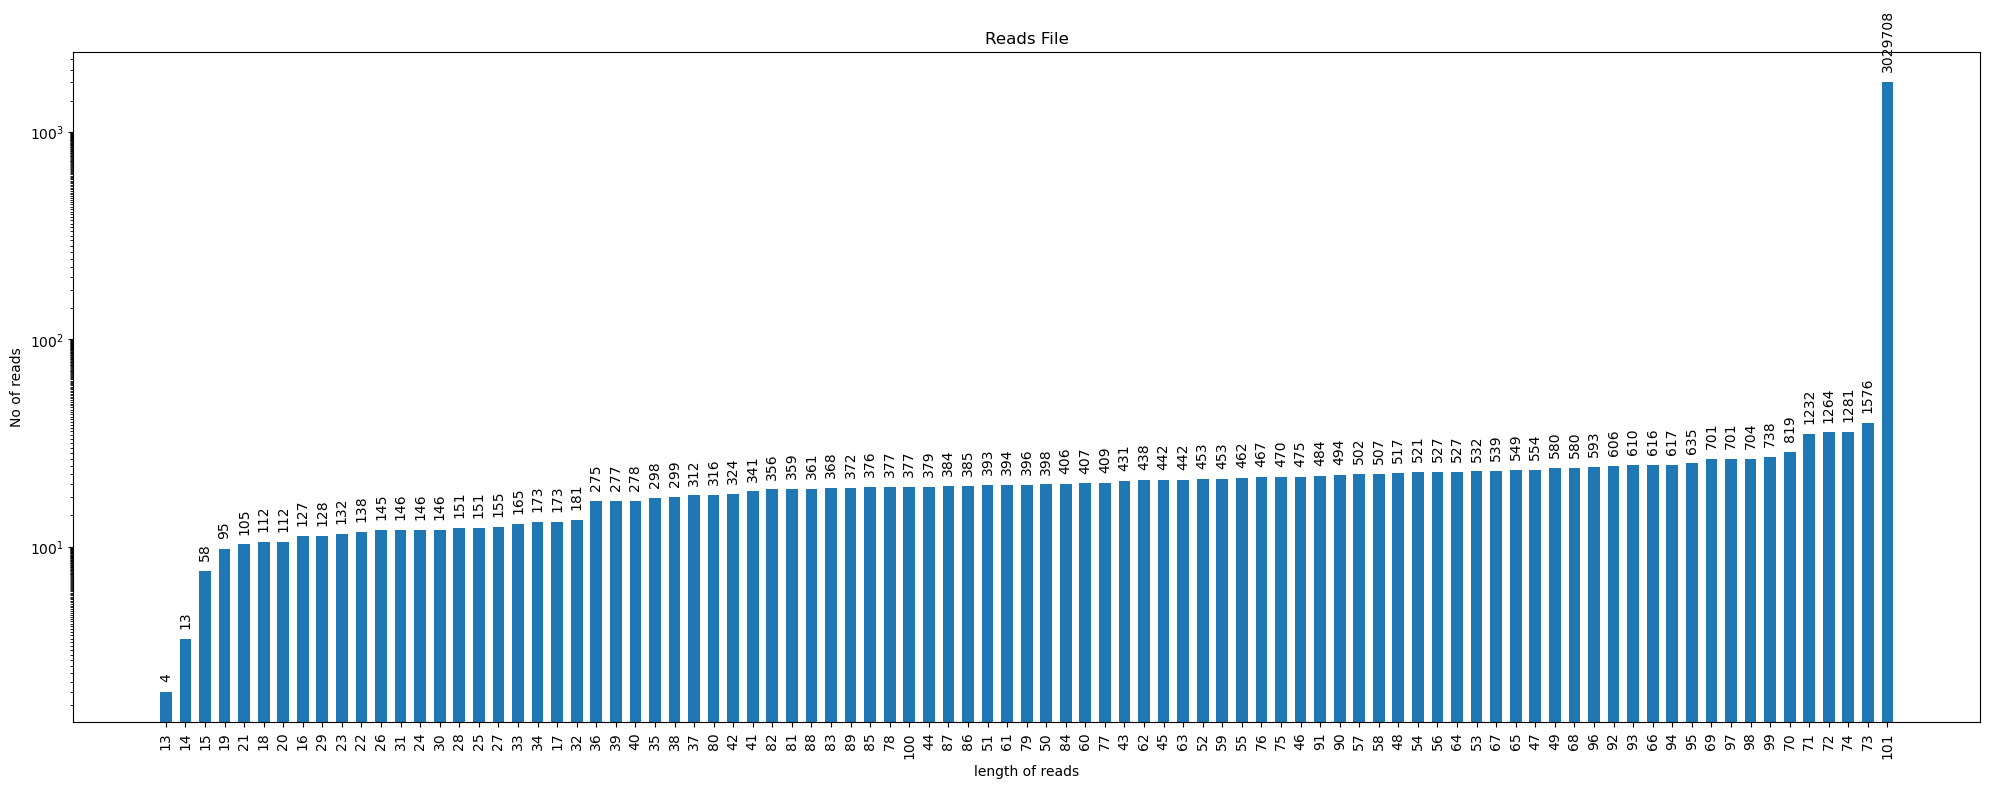

In [144]:
labels = df['length']
values = df['vals']
plt.figure(figsize=(20, 8))
bar_width = 0.6
bar_positions = np.arange(len(values))
plt.bar(bar_positions, values, width=bar_width)
plt.yscale('log', base=100)
plt.xticks(bar_positions, labels, rotation=90)
for index, value in enumerate(values):
    k = value * 0.35
    plt.text(index, value+k, str(value), ha='center', rotation=90)
plt.xlabel('length of reads')
plt.ylabel('No of reads')
plt.title('Reads File')
plt.tight_layout()
plt.show()


TASK2--> Understanding how bases are divided in red and green genes in the reference genome

In [145]:
red_exons = [[149249757, 149249868], [149256127, 149256423], [149258412, 149258580], [
    149260048, 149260213], [149261768, 149262007], [149264290, 149264400]]
green_exons = [[149288166, 149288277], [149293258, 149293554], [149295542, 149295710], [
    149297178, 149297343], [149298898, 149299137], [149301420, 149301530]]
cols = ['exons','length','A','C','G','T']
df_red_exons = pd.DataFrame(columns=cols)
df_green_exons = pd.DataFrame(columns=cols)
df_total_exons = pd.DataFrame(columns=cols)
for i in range(len(red_exons)) :
    leng = red_exons[i][1]-red_exons[i][0]
    counts = get_count(ref_seq[red_exons[i][0]:red_exons[i][1]])
    df_red_exons.loc[i] = [red_exons[i],leng,counts[0],counts[1],counts[2],counts[3]]
for i in range(len(green_exons)) :
    leng = green_exons[i][1]-green_exons[i][0]
    counts = get_count(ref_seq[green_exons[i][0]:green_exons[i][1]])
    df_green_exons.loc[i] = [green_exons[i],leng,counts[0],counts[1],counts[2],counts[3]]

In [146]:
df_red_exons

,exons,length,A,C,G,T
0,"[149249757, 149249868]",111,31,42,25,13
1,"[149256127, 149256423]",296,55,93,78,70
2,"[149258412, 149258580]",168,24,42,54,48
3,"[149260048, 149260213]",165,28,57,41,39
4,"[149261768, 149262007]",239,51,69,60,59
5,"[149264290, 149264400]",110,22,30,28,30


In [147]:
df_green_exons

,exons,length,A,C,G,T
0,"[149288166, 149288277]",111,31,42,25,13
1,"[149293258, 149293554]",296,54,91,80,71
2,"[149295542, 149295710]",168,26,42,53,47
3,"[149297178, 149297343]",165,28,58,42,37
4,"[149298898, 149299137]",239,49,71,60,59
5,"[149301420, 149301530]",110,22,30,28,30


In [148]:

for i in range(len(green_exons)) :
    diffs = 0
    seq1 = ref_seq[red_exons[i][0]:red_exons[i][1]]
    seq2 = ref_seq[green_exons[i][0]:green_exons[i][1]]
    for j in range(len(seq1)) :
        if (seq1[j] != seq2[j]) :
            diffs += 1
            print(seq1[j],"---",seq2[j])
    print(i+1,"- exon diffs -",diffs)

1 - exon diffs - 0
C --- T
A --- G
A --- G
C --- A
2 - exon diffs - 4
G --- A
C --- A
G --- C
T --- G
3 - exon diffs - 4
T --- C
G --- A
C --- G
T --- C
A --- G
4 - exon diffs - 5
A --- G
T --- C
T --- G
G --- A
A --- T
G --- T
C --- A
A --- G
T --- C
G --- C
A --- T
5 - exon diffs - 11
6 - exon diffs - 0


In [149]:
counts = get_count(ref_seq[red_exons[0][0]-150:green_exons[5][1]+150])
df_total_exons.loc[0] = [[red_exons[0][0]-150,green_exons[5][1]+150],green_exons[5][1]+150-red_exons[0][0]-150,counts[0],counts[1],counts[2],counts[3]]
df_total_exons

,exons,length,A,C,G,T
0,"[149249607, 149301680]",51773,13105,13657,13054,12257


TASK3--> Create the suffix tree for the reference sequence and find number of reads found in the suffix tree

In [150]:
# Creatingthe suffix tree using package STree
start = datetime.now()
st = STree.STree(ref_seq[149249657:149301631])
end = datetime.now()    
print((end-start))

0:00:00.121357


In [151]:
start = datetime.now()
filen = "reads"
count = 0
with open(filen, "r") as file:
    for index, line in enumerate(file):
        line = line.strip()
        if st.find(line) != -1 :
            count = count + 1
    file.close()
    # print(reads_found)
end = datetime.now()
print(end-start)
print(count)

0:00:18.877089
6867


In [152]:
start = datetime.now()
# filen = "reverse_complments_of_reads"
filen = "reads"
i=0
reads_found_new = []
with open(filen, "r") as file:
    for index, line in enumerate(file):
        line = line.strip()
        if 'n' in line:
            print(index)
        found = st.find_all(line)
        if len(found) > 0 :
            i += len(found)
            reads_found_new.append([index,found])
    file.close()
end = datetime.now()
print(end-start)
print(i)

0:00:18.262797
8596


In [153]:
# reads found in suffix tree and there starting index
(reads_found_new[0:20])

[[2936866, {62, 38471}],
 [2936872, {72, 38481}],
 [2936874, {77, 38486}],
 [2936875, {78, 38487}],
 [2936876, {78, 38487}],
 [2936878, {79, 38488}],
 [2936879, {80, 38489}],
 [2936880, {80, 38489}],
 [2936881, {80, 38489}],
 [2936882, {80, 38489}],
 [2936883, {81, 38490}],
 [2936884, {82, 38491}],
 [2936885, {83, 38492}],
 [2936888, {86, 38495}],
 [2936889, {86, 38495}],
 [2936891, {87, 38496}],
 [2936892, {87, 38496}],
 [2936897, {89, 38498}],
 [2936898, {90, 38499}],
 [2936899, {92, 38501}]]

TASK4--> implement the rank function and select funtion on bit array with max int32 as its length

In [14]:
# Rank algorithm
# This functions used for the the purpose of bit array 
# 2147483647
delta = None

rank_array = []
def rank_of_index_0(arr,index) : 
    a, b = divmod(index, delta)
    ch = arr[index]
    rank = 0
    # case = 0
    if b == 0 :
        return rank_array[a].get(ch,0)
    for i in range(a*delta+1, index+1):
        if arr[i] == ch:
            rank += 1
    return rank + rank_array[a].get(ch,0)
def rankarrayfinder_0(arr) :
    rank_array = []
    char_dict = {}
    for i in range(len(arr)) : 
        char_dict[arr[i]] = char_dict.get(arr[i],0) + 1
        if i % delta == 0 :
            rank_array.append(char_dict.copy())
    return rank_array

            


In [27]:
#bit array of size 2^31-1 and replacing zeros with 1's randomly
bits_array = bitarray(int_max)
random_ones = set()
for i in range(int_max//100) :
    random_ones.add(random.randint(0, int_max-1))
for i in random_ones:
    bits_array[i] = 1

In [19]:
#generating random indexs
indexs_to_find_rank = set()
for i in range(500) :
    indexs_to_find_rank.add(random.randint(0, int_max-1))

In [20]:
# finding ranks using rank array and using rank of index function
times = []
deltas = []
memory_rank_array = []
for i in range(1) :
    delta = 1000
    print(delta)
    rank_array = []  # list of dictionaries containing rank of each character at multiples of delta(index)
    ranks_of_index = [] 
    sequence = bits_array
    start = datetime.now()
    rank_array = rankarrayfinder_0(sequence)
    end = datetime.now()
    print((end-start).total_seconds(),"seconds for generating rank array")
    print(sys.getsizeof(rank_array),"memory of rank array")
    memory_rank_array.append(sys.getsizeof(rank_array))
    start = datetime.now()
    for i in indexs_to_find_rank :
        ranks_of_index.append(rank_of_index_0(sequence,i))
    end = datetime.now()
    deltas.append(delta)
    times.append((end - start).total_seconds())

1000
261.849734 seconds for generating rank array
19269336 memory of rank array


In [21]:
print(deltas)
print(times)
print(memory_rank_array)

[1000]
[0.013324]
[19269336]


##### "for bits array"
 print(deltas)

 print(times)

 print(memory_rank_array)

 [1000, 10000, 100000, 1000000, 10000000, 100000000]

 [0.000902, 0.001088, 0.00232, 0.016337, 0.145569, 1.483583]

 [19269336, 1827096, 173016, 18232, 1912, 248]


##### Delta value,corresponding time taken and memory took by rank array
 1000

 255.427145 seconds for generating rank array

 19269336 memory of rank array in bytes

 10000

 257.821521 seconds for generating rank array

 1827096 memory of rank array in bytes

 100000

 258.667908 seconds for generating rank array

 173016 memory of rank array in bytes

 1000000

 259.160218 seconds for generating rank array

 18232 memory of rank array in bytes

 10000000

 258.083201 seconds for generating rank array

 1912 memory of rank array in bytes

 100000000

 261.207908 seconds for generating rank array
 
 248 memory of rank array in bytes

for chrx_last_column file delta values and corresponding time taken

        ||

print(last_column_Deltas) 

print(last_column_times)

[10000, 100000, 1000000, 10000000, 100000000]

[11.353326, 13.639996, 16.236813, 18.906482, 47.598378]

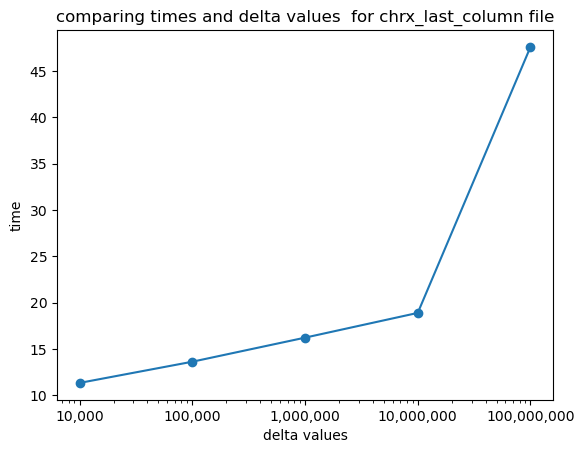

In [154]:

last_column_Deltas= [10000, 100000, 1000000, 10000000, 100000000]
last_column_times = [11.353326, 13.639996, 16.236813, 18.906482, 47.598378]
plt.plot(last_column_Deltas, last_column_times, marker='o') 
plt.xlabel('delta values')
plt.ylabel('time')
plt.title('comparing times and delta values  for chrx_last_column file')
plt.xscale('log')
plt.xticks(last_column_Deltas, [f'{val:,}' for val in last_column_Deltas])

plt.show()


In [15]:
# This direct funtion is taking very less time compared to above code to run fir bits array only
# normallty finding the frequencies to ensure above functions correctness.
k=0
for i in indexs_to_find_rank:
    rank = sequence[:i+1].count(sequence[i])
    if ranks_of_index[k] != rank :
        print(ranks_of_index[k],rank,i,sequence[i+1])
    k+=1

In [23]:
test_read = "GGCCCAATTAAGAGATCAGGTAGTGTAGGGTTTGGGAGCTTTTAAGGTGAAGAGGCCCGGGCTGATCCCACAGGCCAGTATAAAGCGCCGTGACCCTCAGG"
index = ref_seq.find(test_read)
if index != -1:
    print(index)
else:
    print("test_read is not found")


149249609


READ ALIGNMENT ALGORITHM STARTS FROM BELOW CELL(FINAL TASK)

In [15]:
# calculates the last column of the bwt matrix
# seq = "$CTCAAAGCCCTCATCTGTCTGCTCTCCCCATAGGGATCACAGGTCTCTGGTCTCTGGCCATCATTTCCTGGGAGAGGTGGCTGGTGGTGTGCAAGCCCTTT"
seq = "$"+ref_seq[149249657:149301631] # main refernce sequence
# seq = "$"+ref_seq

seq2 = divsufsort(str(seq)) # seq2 contains the map array for the first column of the bwt matrix
print("length of the map array "+str(len(seq2)))
last_col=bwt.bwt(seq) # calculate the last column of the bwt matrix
def convertTuple(tup):
    str = ''.join(tup)
    return str
last_col = (convertTuple(last_col[0]))
first_col_dict = {}   #stores the first column of the bwt matrix
for i in last_col :
    first_col_dict[i] = first_col_dict.get(i,0) + 1
# last_col = last_column
print("length of the  last column "+str(len(seq)))
print(sys.getsizeof(seq),"memory of reference sequence array in bytes")
print(sys.getsizeof(last_col),"memory of last column array in bytes")
print(sys.getsizeof(seq2),"memory of map array or indexs of first column in bwt matrix in bytes")
print(sys.getsizeof(first_col_dict),"memory of first column includingthere ranks in bwt matrix in bytes")

/home/sainadh_strand/anaconda3/lib/python3.9/site-packages/pydivsufsort/divsufsort.py:75: UserWarning: converting str argument uses more memory
  warnings.warn("converting str argument uses more memory")


length of the map array 51975
length of the  last column 51975
52024 memory of reference sequence array in bytes
52024 memory of last column array in bytes
112 memory of map array or indexs of first column in bwt matrix in bytes
232 memory of first column includingthere ranks in bwt matrix in bytes


In [16]:
#finding the ranges of green exons and red exons wrt to the reference genome that was taken above
print(red_exons)
print(ref_seq[red_exons[1][0]:red_exons[1][1]][0:101])
print(seq.find(ref_seq[red_exons[0][0]:red_exons[0][1]]))
ranges_of_red_exons_in_seq = []
ranges_of_green_exons_in_seq = []
for i in red_exons : 
    ranges_of_red_exons_in_seq.append((re.search(ref_seq[i[0]:i[1]],seq)).span())
for i in green_exons :
    ranges_of_green_exons_in_seq.append((list(re.finditer(ref_seq[i[0]:i[1]], seq))[-1].start(),list(re.finditer(ref_seq[i[0]:i[1]], seq))[-1].end()))
print(ranges_of_green_exons_in_seq)
print(ranges_of_red_exons_in_seq)
print(seq[ranges_of_green_exons_in_seq[5][0]:ranges_of_green_exons_in_seq[5][1]]==seq[ranges_of_red_exons_in_seq[5][0]:ranges_of_red_exons_in_seq[5][1]])
print(seq[ranges_of_green_exons_in_seq[0][0]:ranges_of_green_exons_in_seq[0][1]])

[[149249757, 149249868], [149256127, 149256423], [149258412, 149258580], [149260048, 149260213], [149261768, 149262007], [149264290, 149264400]]
GCCCCTTCGAAGGCCCGAATTACCACATCGCTCCCAGATGGGTGTACCACCTCACCAGTGTCTGGATGATCTTTGTGGTCACTGCATCCGTCTTCACAAAT
101
[(38510, 38621), (43602, 43898), (45886, 46054), (47522, 47687), (49242, 49481), (51764, 51874)]
[(101, 212), (6471, 6767), (8756, 8924), (10392, 10557), (12112, 12351), (14634, 14744)]
True
ATGGCCCAGCAGTGGAGCCTCCAAAGGCTCGCAGGCCGCCATCCGCAGGACAGCTATGAGGACAGCACCCAGTCCAGCATCTTCACCTACACCAACAGCAACTCCACCAGA


In [17]:
def rank_of_index(arr,index,ch,delta3) :  
    a, b = divmod(index, delta3)
    rank = 0
    if b == 0 :
        return rank_array[a].get(ch,0)
    for i in range(a*delta3+1, min(len(arr),index+1)):
        if arr[i] == ch:
            rank += 1
    return rank + rank_array[a].get(ch,0)
def rankarrayfinder(arr,delta3) :
    rank_array = []
    char_dict = {}
    for i in range(len(arr)) : 
        char_dict[arr[i]] = char_dict.get(arr[i],0) + 1
        if i % delta3 == 0 :
            rank_array.append(char_dict.copy())
    return rank_array


In [18]:
#Writing function for delta 2 for map array


# delta2 = 10
seq2_f = [] # map array
def find_seq(seq2,delta2) :
    seq2_f = []
    for i in range(len(seq2)) :
        if i % delta2 == 0 :
            seq2_f.append(seq2[i])
    return seq2_f

def find_index_of_reference(last_col,seq2_f,delta2,index_to_find,delta1) :
    a,b = divmod(index_to_find,delta2)
    no_of_ops = 0
    if b ==0 : return seq2_f[a]
    while index_to_find % delta2 != 0 :
        no_of_ops += 1
        rank_of_index_present_char = rank_of_index(last_col,index_to_find,last_col[index_to_find],delta1)-1
        present_ch = last_col[index_to_find]
        k=0
        for key,value in first_col_dict.items() :
            if key < present_ch :
                k += value
        index_to_find = k+rank_of_index_present_char
    return (seq2_f[index_to_find//delta2]+no_of_ops)%len(last_col)

# seq2_f = find_seq(seq2,1)


In [19]:
def find_first_occurence(ch) : # finds the first occurrence fo the starting letter of given pattern
    start = 0
    end = 0
    for key,value in first_col_dict.items():
        if ch>key :
            start += value
    end = start + first_col_dict.get(ch,0) - 1
    return start,end
def selectfuntion(rank,ch) : #takes rank and convert them to indexs for last column
    start = 0
    end = 0
    for key,value in first_col_dict.items():
        if ch>key :
            start += value
    end = start + rank[1]
    start = start + rank[0]
    return start,end
def rank_function(select,ch,delta1) : #takes the indexs and gives ranks of next character in the band
    start = rank_of_index(last_col,select[0],ch,delta1)
    end = rank_of_index(last_col,select[1],ch,delta1)
    if start == end and last_col[select[0]] != ch:
        global k
        k=k+1
        return -1,-1
    if last_col[select[0]] == ch :
        start -= 1
    # if last_col[select[1]] == ch :
    end -= 1
    return start,end


#first_occurence
#rank_of_index
#selectfuntion
################################
#rank_of_index
#selectfuntion
#......
#......

In [20]:

patterns_found = 0 # number of patterns found in the reference sequence including the multiple positions

def pattern_matching(pattern,delta1):
    start = 0 
    end = 0
    if len(pattern) == 1 :
        start,end = find_first_occurence(pattern[0])
        return [start,end]
    for i in range(0, len(pattern)-1) :
        if i == 0 :
            start,end = find_first_occurence(pattern[i]) #gives start and end of first character of pattern
            indexs = [start,end] 
            # print(indexs)

        start,end = rank_function(indexs,pattern[i+1],delta1) #gives rank of start and rank of end indexs 
        if start == -1 and end == -1 :
            return [-1,-1]
        rank = [start,end]
        # print(rank)

        start,end = selectfuntion(rank,pattern[i+1]) #gives start and end indexs of pattern
        indexs = [start,end]

        if i == len(pattern)-2 :
            global patterns_found
            patterns_found += (1+indexs[1]-indexs[0])
            return indexs


In [21]:
# finding the patterns with certain no of mismatches
# @profile
# tracemalloc.start()

def pattern_missmatching(pattern,no_of_mismatches,delta1,delta2) :
    n = len(pattern)
    a = n // (no_of_mismatches+1)
    pattern_to_match = pattern[::-1]
    ranges_founded_patterns = set()
    if no_of_mismatches > 0 :
        divided_patterns = [[i,min(i+a,len(pattern))] for i in range(0,len(pattern),a)]
        if (divided_patterns[-1][1]-divided_patterns[-1][0]) < a :
            divided_patterns[-2][1] = len(pattern) 
            del divided_patterns[-1]
        for i in divided_patterns :
            indexs = pattern_matching(pattern[i[0]:i[1]][::-1],delta1)
            if indexs[1] != -1 or indexs[0] != -1 :
                for j in range(indexs[0],indexs[1]+1) :
                    miss_matches = 0                      # making zero on every iteration (no of miss matches for that divided pattern)
                    sub_start = i[0]
                    sub_end = i[1]-1
                    ################################################################################################
                    ref_string_start_pos = seq2[j]
                    ref_string_end_pos = seq2[j] + sub_end - sub_start
                    ################################################################################################
                    # b = find_index_of_reference(last_col,seq2_f,delta2,j)
                    # ref_string_start_pos =  b
                    # ref_string_end_pos = b + sub_end - sub_start
                    ################################################################################################
                    while sub_start >= 0 and ref_string_start_pos >=0 :
                        if seq[ref_string_start_pos] != pattern[sub_start] :
                            miss_matches += 1
                        sub_start -= 1
                        ref_string_start_pos -= 1
                    while sub_end < len(pattern) and ref_string_end_pos<len(seq):
                        if seq[ref_string_end_pos]!= pattern[sub_end] :
                            miss_matches += 1
                        sub_end += 1
                        ref_string_end_pos += 1
                    if sub_start != -1 or sub_end != len(pattern) or miss_matches > no_of_mismatches :
                        # print("Gap has occured or no of mistaches are greater than no of missmatches ",miss_matches)
                        global k   # keep track of no of reads that not found in the reference sequence
                        k = k
                    else :
                        ranges_founded_patterns.add((ref_string_start_pos+1,ref_string_end_pos-1)) #include start , not the end index(ref_string_end_pos)
                        # print("pattern has occured at ",ref_string_start_pos,ref_string_end_pos," with no of mismatches is",miss_matches)
    else :
        final_indexs = pattern_matching(pattern_to_match,delta1)
        if final_indexs[1]!= -1 and final_indexs[0] != -1 :
            for i in final_indexs :
                b = find_index_of_reference(last_col,seq2_f,delta2,i,delta1)
                ranges_founded_patterns.add((b,b+len(pattern_to_match)-1))
                # ranges_founded_patterns.add((seq2[i],seq2[i]+len(pattern_to_match)-1))
    return ranges_founded_patterns
        
# tracemalloc.clear_traces()
# snapshot1 = tracemalloc.take_snapshot()    

In [86]:
# checking for all reads in reads file with reference using bwt
Delta1 = 1
Delta2 = 1
no_of_missmatches = 1
filen = "reads"
# filen = "reverse_complments_of_reads"
reads_found = []
final_range_of_divided_pattern = []
count = 0
patterns_found= 0
k=0
rank_array = rankarrayfinder(last_col,Delta1)  # second parameter is Delta1
print(sys.getsizeof(rank_array),"memory of rank array in bytes")
seq2_f = find_seq(seq2,Delta2)   # second parameter is Delta2
print(sys.getsizeof(seq2_f),"memory of map array in bytes")
start = datetime.now()
with open(filen, "r") as file:
    for index, line in enumerate(file):
        line = line.strip()
        # line  = line.replace('N',"")
        ranges_of_divided_patterns = pattern_missmatching(line,no_of_missmatches,Delta1,Delta2) # 3rd parameter is Delta1 and 4th parameter is Delta2
        final_range_of_divided_pattern.append((index,ranges_of_divided_patterns))
    file.close()

end = datetime.now()


# memory usage statistics
# snapshot2 = tracemalloc.take_snapshot()
# top_stats = snapshot2.compare_to(snapshot1, 'lineno')
# formatted_stats = []
# for stat in top_stats:
#     formatted_stat = {
#         'line': stat.traceback[0].lineno,
#         'filename': stat.traceback[0].filename,
#         'size': pretty_size(stat.size),
#         'difference': pretty_size(stat.size_diff),
#     }
#     formatted_stats.append(formatted_stat)

# pprint(formatted_stats)



print(end-start)
print(patterns_found,"no of reads found in  reference sequence even considering the multiple positions")
print(k,"reads are not found in reference sequence")

444376 memory of rank array in bytes
444376 memory of map array in bytes
0:01:01.873061
22640 no of reads found in  reference sequence even considering the multiple positions
6116531 reads are not found in reference sequence


In [87]:
# funtion that write mismatches indexs and range of them in reference sequence

def write_mismatches_to_file(filen) :
    file_obj = open(filen, "w")
    for i in final_range_of_divided_pattern:
        file_obj.write(str(i)+"\n")
    file_obj.close()

write_mismatches_to_file(f"ranges_of_reads_file_patterns_for_{no_of_missmatches}_missmatches.1")

In [76]:
def precentage_of_read_in_exon_range(a,b,pair) :
    if a>=pair[0] and b<=pair[1] :
        return 100
    elif a>=pair[0] :
        return (((pair[1]-a+1)/(pair[1]-pair[0]+1)))*100
    elif b<=pair[1] :
        return (((b-pair[0]+1)/(pair[1]-pair[0]+1)))*100
    else :
            return 0

In [174]:
red_exons_count = [0,0,0,0,0,0]
green_exons_count = [0,0,0,0,0,0]
reads_count_found_in_both_exons =[0,0,0,0,0,0]
reads_found_in_both_genes = []
precentages_red_to_green_exons_count = []
counter = 0
# Total_no_of_reads_found = 0
file_obj = open("ranges_of_reads_file_patterns_for_0_missmatches.1", "r")
# file_obj = open("ranges_of_reads_complements_file_patterns_for_3_missmatches",'r')
for index,line in enumerate(file_obj):
    line=line.strip()
    if "set" not in line:
        z = re.findall(r'-?\d+', line)
        numbers = [int(x) for x in z]
        found = -1
        for i in range(1,len(numbers),2) :
            # Total_no_of_reads_found+=1
            for j in range(len(ranges_of_red_exons_in_seq)) :
                zz=precentage_of_read_in_exon_range(numbers[i],numbers[i+1],ranges_of_red_exons_in_seq[j])
                if(zz>=25) :
                # if (numbers[i] >= ranges_of_red_exons_in_seq[j][0] and numbers[i] <= ranges_of_red_exons_in_seq[j][1]) or  (numbers[i+1] >= ranges_of_red_exons_in_seq[j][0] and numbers[i+1] <= ranges_of_red_exons_in_seq[j][1]) : 
                    red_exons_count[j] += 1
                    found = j
                    
        for i in range(1,len(numbers),2) :
            for j in range(len(ranges_of_green_exons_in_seq)) :
                zz=precentage_of_read_in_exon_range(numbers[i],numbers[i+1],ranges_of_green_exons_in_seq[j])
                if(zz>=25) :
                # if ((numbers[i] >= ranges_of_green_exons_in_seq[j][0] and numbers[i] <= ranges_of_green_exons_in_seq[j][1]) or (numbers[i+1] >= ranges_of_green_exons_in_seq[j][0] and numbers[i+1] <= ranges_of_green_exons_in_seq[j][1])) :
                    if found == -1 :
                        green_exons_count[j] += 1
                    elif j>0 and j<5 :
                        red_exons_count[found] -= 1
                        reads_found_in_both_genes.append([numbers[0],found,j])
                        reads_count_found_in_both_exons[found] += 1





for i in range(1,len(red_exons_count)-1) :
    precentages_red_to_green_exons_count.append(round((red_exons_count[i]/green_exons_count[i])*100,2))
    file_obj.close()
# print(str(Total_no_of_reads_found)+" no of reads found")

In [175]:
print("Adding 50% of reads to exons that foundin both exons")
print("for 0 mismatches")
print([red_exons_count[i]+reads_count_found_in_both_exons[i]//2 for i in range(len(red_exons_count))])
print([green_exons_count[i]+reads_count_found_in_both_exons[i]//2 for i in range(len(green_exons_count))])
for i in range(1,len(red_exons_count)-1) :
    print(str(i+1)+" exons "+str(round(((red_exons_count[i]+reads_count_found_in_both_exons[i]//2)/(green_exons_count[i]+reads_count_found_in_both_exons[i]//2))*100,2)))

Adding 50% of reads to exons that foundin both exons
for 0 mismatches
[163, 58, 37, 98, 173, 510]
[31, 187, 58, 95, 228, 0]
2 exons 31.02
3 exons 63.79
4 exons 103.16
5 exons 75.88


In [176]:
print("Adding 33% of reads to green exons that found both exons")
print("for 2 mismatches")   
print([red_exons_count[i]+reads_count_found_in_both_exons[i]//3 for i in range(len(red_exons_count))])
print([green_exons_count[i]+2*(reads_count_found_in_both_exons[i]//3) for i in range(len(green_exons_count))])
for i in range(1,len(red_exons_count)-1) :
    print(str(i+1)+" exons "+str(round(((red_exons_count[i]+reads_count_found_in_both_exons[i]//2)/(green_exons_count[i]+2*(reads_count_found_in_both_exons[i]//2)))*100,2)))

Adding 33% of reads to green exons that found both exons
for 2 mismatches
[163, 56, 37, 92, 171, 510]
[31, 187, 58, 100, 231, 0]
2 exons 30.37
3 exons 63.79
4 exons 87.5
5 exons 73.62


In [127]:
print("for 0 mismatches")
print(red_exons_count)
print(green_exons_count)    
for i in range(len(precentages_red_to_green_exons_count)) :
    print(f"exons {i+2} percentage {precentages_red_to_green_exons_count[i]}%")
print(reads_count_found_in_both_exons)

for 0 mismatches
[345, 23, 26, 119, 187, 845]
[49, 73, 83, 92, 249, 0]
exons 2 percentage 31.51%
exons 3 percentage 31.33%
exons 4 percentage 129.35%
exons 5 percentage 75.1%
[0, 308, 169, 141, 293, 0]


In [24]:
print("for 1 mismatches")
print(red_exons_count)
print(green_exons_count)
for i in range(len(precentages_red_to_green_exons_count)) :
    print(f"exons {i+2} percentage {precentages_red_to_green_exons_count[i]}%")
print(reads_count_found_in_both_exons)

for 2 mismatches
[200, 55, 37, 83, 166, 657]
[50, 184, 58, 78, 224, 0]
exons 2 percentage 29.89%
exons 3 percentage 63.79%
exons 4 percentage 106.41%
exons 5 percentage 74.11%
[0, 46, 49, 82, 182, 0]


In [99]:
print("for 3 mismatches")
print(red_exons_count)
print(green_exons_count)
for i in range(len(precentages_red_to_green_exons_count)) :
    print(f"exons {i+2} percentage {precentages_red_to_green_exons_count[i]}%")
print(reads_count_found_in_both_exons)

for 3 mismatches
[379, 12, 14, 118, 154, 865]
[36, 31, 42, 93, 211, 0]
exons 2 percentage 38.71%
exons 3 percentage 33.33%
exons 4 percentage 126.88%
exons 5 percentage 72.99%
[0, 377, 239, 151, 383, 0]


In [101]:
print("for 4 mismatches")
print(red_exons_count)
print(green_exons_count)
for i in range(len(precentages_red_to_green_exons_count)) :
    print(f"exons {i+2} percentage {precentages_red_to_green_exons_count[i]}%")
print(reads_count_found_in_both_exons)

for 4 mismatches
[403, 5, 4, 107, 149, 876]
[28, 10, 10, 89, 197, 0]
exons 2 percentage 50.0%
exons 3 percentage 40.0%
exons 4 percentage 120.22%
exons 5 percentage 75.63%
[0, 415, 293, 177, 423, 0]


In [107]:
print("for 5 mismatches")
counter = 0
print(red_exons_count)
print(green_exons_count)
for i in range(len(precentages_red_to_green_exons_count)) :
    print(f"exons {i+2} percentage {precentages_red_to_green_exons_count[i]}%")
print(reads_count_found_in_both_exons)
for i in reads_found_in_both_genes :
    if i[1]!=i[2] :
        print(i[1],i[2])
        counter += 1
print(counter)

for 5 mismatches
[440, 320, 174, 173, 336, 886]
[9, 4, 6, 25, 177, 0]
exons 2 percentage 8000.0%
exons 3 percentage 2900.0%
exons 4 percentage 692.0%
exons 5 percentage 189.83%
[0, 138, 154, 191, 288, 0]
2 1
1
